In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm

from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
#Transmit Power
P=1
#Power splitting ratio
rho = 1
#Power loss of splitter
eps = 1
#variance of antenna noise
w = 1
#rectifier efficiency
eta=1
noise_std = 1
print('number of symbols:',M)


number of symbols: 16


In [ ]:
def set_up_train_nn(P,EsNodB):
    
    label = np.random.randint(M,size=N)
    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)
        # checking data shape
    data = np.array(data)
    print (data.shape)
    es = EarlyStopping(monitor='val_loss',patience=15, verbose=1)
    #callbacks = [EarlyStoppingByAccuracy(monitor='accuracy', value=0.98, verbose=1)]
    # Defined Autoencoder
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded = Dense(8,activation='relu')(encoded)
    encoded = Dense(4,activation='relu')(encoded)
    encoded2 = Dense(n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    
    encoded4 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #Add antenna noise
    encoded5 = Lambda(lambda x: x+K.random_normal_variable((2*4096,1), 0, 1)[0:tf.shape(x)[0],:])(encoded4)

    # Making PD data, and applying noise
    pd_data = Lambda(lambda x: K.square(x))(encoded5)

    # Reciever Layer
    decoded = Dense(1, activation='linear')(encoded5)
    decoded = Dense(4,activation='relu')(decoded)
    decoded = Dense(8,activation='relu')(decoded)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.075)
    epochs=65
    sgd = SGD(lr=0.075)
    
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    

    # traning auto encoder
    history = autoencoder.fit(data, data,epochs=epochs,batch_size=4096,callbacks=[es],validation_split=0.3)
    
    
    # list all data in history
    print(history.history.keys())
    
    results = autoencoder.evaluate(data, data, batch_size=2*2048)
    print('test loss, test acc:', results)

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded4)
    
    
    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)
    
    # ploting constellation diagram
    
    

    plt.scatter([i for i in range(0,M)],scatter_plot)
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' P = '+str(P))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)
    
    return autoencoder

(45000, 16)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 31499 samples, validate on 13501 samples
Epoch 1/65
31499/31499 [==============================] - 6s 191us/step - loss: 2.6567 - acc: 0.1047 - val_loss: 2.5446 - val_acc: 0.1110
Epoch 2/65
31499/31499 [==============================] - 1s 22us/step - loss: 2.5903 - acc: 0.1068 - val_loss: 2.5525 - val_acc: 0.1195
Epoch 3/65
31499/31499 [==============================] - 1s 33us/step - loss: 2.5817 - acc: 0.1152 - val_loss: 2.5632 - val_acc: 0.1195
Epoch 4/65
31499/31499 [==============================] - 0s 15us/step - loss: 2.5781 - acc: 0.1155 - val_loss: 2.5668 - val_acc: 0.1164
Epoch 5/65
31499/31499 [==============================] - 0s 12us/step - loss: 2.5762 - acc: 0.1164 - val_loss: 2.5609 - val_acc: 0.1228
Epoch 6/65
31499/31499 [==============================] - 0s 11us/step - loss: 2.5734 - acc: 0.1163 - val_loss: 2.5687 - val_acc: 0.

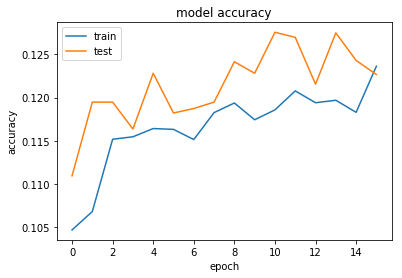

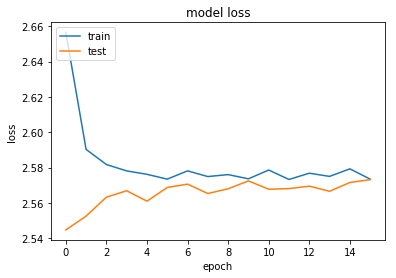

(16, 1, 1)


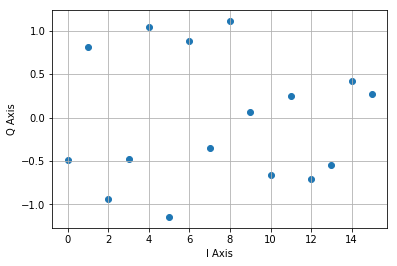

[0.50369537]
SNR: 0 SER: 0.8548444444444444 Theor_SER: 0.8232078436042176
(55000, 16)
Train on 38500 samples, validate on 16500 samples
Epoch 1/65
38500/38500 [==============================] - 4s 116us/step - loss: 2.4969 - acc: 0.1159 - val_loss: 2.2626 - val_acc: 0.1470
Epoch 2/65
38500/38500 [==============================] - 0s 9us/step - loss: 2.3024 - acc: 0.1484 - val_loss: 2.2479 - val_acc: 0.1539
Epoch 3/65
38500/38500 [==============================] - 0s 10us/step - loss: 2.2592 - acc: 0.1490 - val_loss: 2.2311 - val_acc: 0.1495
Epoch 4/65
38500/38500 [==============================] - 0s 10us/step - loss: 2.2505 - acc: 0.1535 - val_loss: 2.2315 - val_acc: 0.1469
Epoch 5/65
38500/38500 [==============================] - 0s 10us/step - loss: 2.2438 - acc: 0.1550 - val_loss: 2.2401 - val_acc: 0.1592
Epoch 6/65
38500/38500 [==============================] - 0s 10us/step - loss: 2.2368 - acc: 0.1619 - val_loss: 2.2343 - val_acc: 0.1610
Epoch 7/65
38500/38500 [==================

38500/38500 [==============================] - 0s 10us/step - loss: 2.2185 - acc: 0.2063 - val_loss: 2.2126 - val_acc: 0.2073
Epoch 60/65
38500/38500 [==============================] - 0s 9us/step - loss: 2.2227 - acc: 0.2014 - val_loss: 2.2204 - val_acc: 0.2067
Epoch 61/65
38500/38500 [==============================] - 0s 9us/step - loss: 2.2223 - acc: 0.2054 - val_loss: 2.2019 - val_acc: 0.2092
Epoch 62/65
38500/38500 [==============================] - 0s 8us/step - loss: 2.2213 - acc: 0.2049 - val_loss: 2.2269 - val_acc: 0.2050
Epoch 63/65
38500/38500 [==============================] - 0s 8us/step - loss: 2.2210 - acc: 0.2038 - val_loss: 2.1863 - val_acc: 0.2135
Epoch 64/65
38500/38500 [==============================] - 0s 9us/step - loss: 2.2248 - acc: 0.2021 - val_loss: 2.1976 - val_acc: 0.2079
Epoch 65/65
38500/38500 [==============================] - 0s 9us/step - loss: 2.2272 - acc: 0.2015 - val_loss: 2.2059 - val_acc: 0.2123
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
55

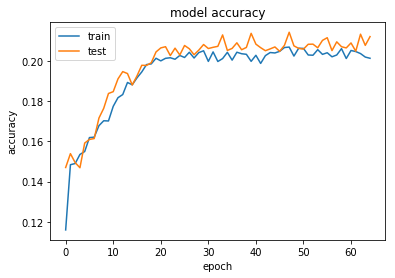

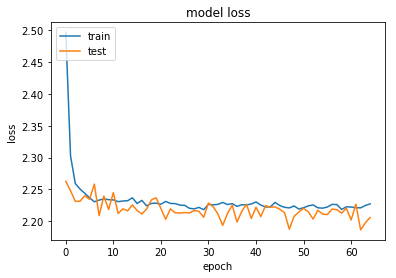

(16, 1, 1)


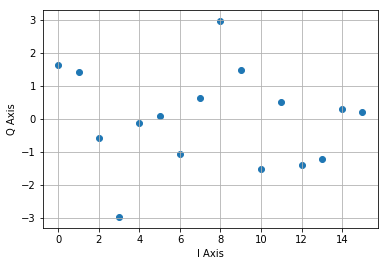

[2.0463457]
SNR: 6 SER: 0.8021272727272727 Theor_SER: 0.712087050228903
(65000, 16)
Train on 45500 samples, validate on 19500 samples
Epoch 1/65
45500/45500 [==============================] - 6s 126us/step - loss: 2.4820 - acc: 0.1277 - val_loss: 2.3029 - val_acc: 0.1928
Epoch 2/65
45500/45500 [==============================] - 0s 10us/step - loss: 2.1543 - acc: 0.1892 - val_loss: 2.0522 - val_acc: 0.2306
Epoch 3/65
45500/45500 [==============================] - 0s 10us/step - loss: 1.9695 - acc: 0.2480 - val_loss: 1.8336 - val_acc: 0.2666
Epoch 4/65
45500/45500 [==============================] - 1s 12us/step - loss: 1.8249 - acc: 0.2622 - val_loss: 1.7469 - val_acc: 0.2790
Epoch 5/65
45500/45500 [==============================] - 0s 10us/step - loss: 1.7890 - acc: 0.2700 - val_loss: 1.7877 - val_acc: 0.2719
Epoch 6/65
45500/45500 [==============================] - 1s 13us/step - loss: 1.7465 - acc: 0.2867 - val_loss: 1.7123 - val_acc: 0.2848
Epoch 7/65
45500/45500 [===================

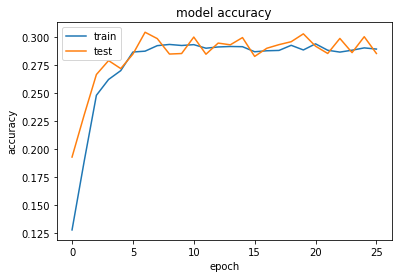

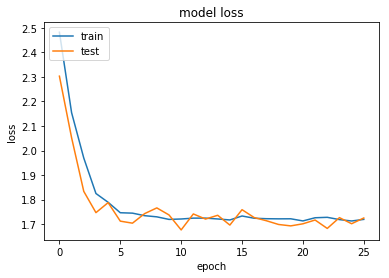

(16, 1, 1)


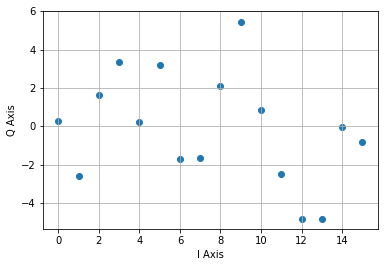

[7.7859297]
SNR: 12 SER: 0.7048923076923077 Theor_SER: 0.5075803579279314
(165000, 16)
Train on 115499 samples, validate on 49501 samples
Epoch 1/65
115499/115499 [==============================] - 6s 51us/step - loss: 1.9331 - acc: 0.2401 - val_loss: 1.6035 - val_acc: 0.3244
Epoch 2/65
115499/115499 [==============================] - 1s 6us/step - loss: 1.4538 - acc: 0.3706 - val_loss: 1.3769 - val_acc: 0.4058
Epoch 3/65
115499/115499 [==============================] - 1s 6us/step - loss: 1.3570 - acc: 0.4003 - val_loss: 1.3266 - val_acc: 0.4147
Epoch 4/65
115499/115499 [==============================] - 1s 7us/step - loss: 1.3285 - acc: 0.4168 - val_loss: 1.3147 - val_acc: 0.4258
Epoch 5/65
115499/115499 [==============================] - 1s 6us/step - loss: 1.3074 - acc: 0.4308 - val_loss: 1.3377 - val_acc: 0.4289
Epoch 6/65
115499/115499 [==============================] - 1s 6us/step - loss: 1.3156 - acc: 0.4288 - val_loss: 1.2997 - val_acc: 0.4351
Epoch 7/65
115499/115499 [=======

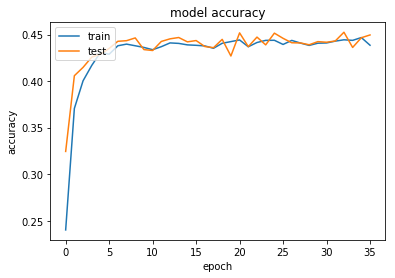

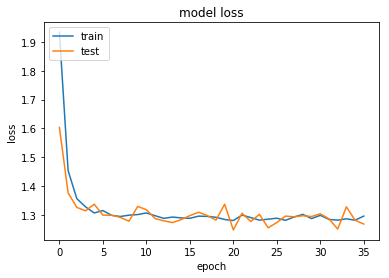

(16, 1, 1)


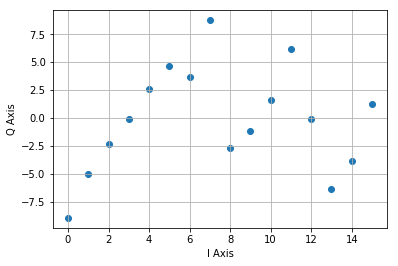

[20.902985]
SNR: 16 SER: 0.5631878787878788 Theor_SER: 0.3123019621637889
(325000, 16)
Train on 227500 samples, validate on 97500 samples
Epoch 1/65
227500/227500 [==============================] - 8s 36us/step - loss: 2.0525 - acc: 0.2290 - val_loss: 1.4097 - val_acc: 0.4116
Epoch 2/65
227500/227500 [==============================] - 2s 10us/step - loss: 1.2974 - acc: 0.4462 - val_loss: 1.2128 - val_acc: 0.4752
Epoch 3/65
227500/227500 [==============================] - 4s 16us/step - loss: 1.1883 - acc: 0.4839 - val_loss: 1.1404 - val_acc: 0.5050
Epoch 4/65
227500/227500 [==============================] - 3s 15us/step - loss: 1.1568 - acc: 0.4891 - val_loss: 1.1523 - val_acc: 0.4919
Epoch 5/65
227500/227500 [==============================] - 3s 12us/step - loss: 1.1325 - acc: 0.4961 - val_loss: 1.1263 - val_acc: 0.5003
Epoch 6/65
227500/227500 [==============================] - 2s 9us/step - loss: 1.1195 - acc: 0.4989 - val_loss: 1.0861 - val_acc: 0.5185
Epoch 7/65
227500/227500 [===

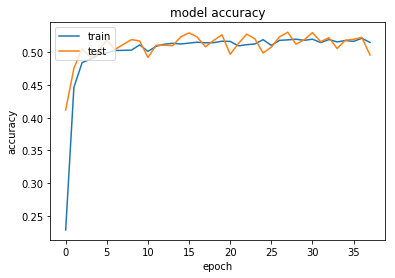

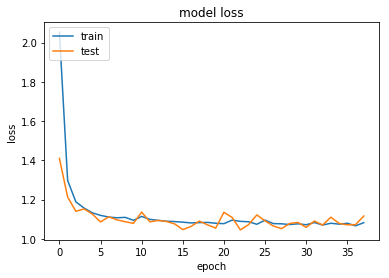

(16, 1, 1)


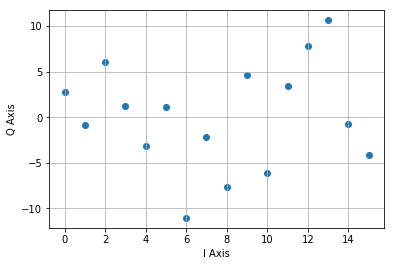

[31.637203]
SNR: 18 SER: 0.5700246153846154 Theor_SER: 0.2091143760439485
(450000, 16)
Train on 315000 samples, validate on 135000 samples
Epoch 1/65
315000/315000 [==============================] - 6s 20us/step - loss: 1.3523 - acc: 0.4360 - val_loss: 1.1501 - val_acc: 0.4861
Epoch 2/65
315000/315000 [==============================] - 2s 6us/step - loss: 0.9255 - acc: 0.5857 - val_loss: 0.8800 - val_acc: 0.6093
Epoch 3/65
315000/315000 [==============================] - 2s 6us/step - loss: 0.9003 - acc: 0.5960 - val_loss: 0.8891 - val_acc: 0.6063
Epoch 4/65
315000/315000 [==============================] - 2s 6us/step - loss: 0.9052 - acc: 0.5949 - val_loss: 0.9060 - val_acc: 0.5947
Epoch 5/65
315000/315000 [==============================] - 2s 6us/step - loss: 0.8910 - acc: 0.6000 - val_loss: 0.8892 - val_acc: 0.5948
Epoch 6/65
315000/315000 [==============================] - 2s 7us/step - loss: 0.9139 - acc: 0.5884 - val_loss: 0.8816 - val_acc: 0.5970
Epoch 7/65
315000/315000 [======

In [ ]:
# Calculating SER from -4dB to 14dB SNR
EsNodB_range = [0,6,12,16,18,20,25]
N_array = [45000,55000,65000,165000,325000,450000,125000]
ser = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

for n in range(0,len(EsNodB_range)):
    
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    no_errors = 0
    
    N = N_array[n]
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
        
    test_data = []
    test_label = np.random.randint(M,size=N)
    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    pred_output = np.argmax(pred_final_signal,axis=1)
    
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = (no_errors/N).astype('float64') 
    
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('SNR:',EsNodB_range[n],'SER:',ser[n],'Theor_SER:',theor_ser[n])

In [ ]:
# ploting BER curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EsNodB_range, theor_ser, 'k^-',label='16 PAM')
plt.plot(EsNodB_range, ser, 'b^-',label='Autoencoder')
plt.yscale('log')
plt.xlabel('Es/No(dB)')
plt.ylabel('Symbol Error Rate')
#plt.ylim((10e-3,10e0))
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()